In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

import datetime
import matplotlib.pyplot as plt

In [2]:
all_columns = ["practiceid",
               "patientid",
               "custid",
               "practicename",
               "production",
               "trn_date",
               "week",
               "month",
               "quarter",
               "year",
               "week_start_date",
               "state",
               "country",
               "description",
               "Code_Category",
               "procedure_code",
               "speciality",
               "ins_transaction",
               "clientid",
               "Product_type",
               "Vendor_Name",
               "manufacturer_name",
               "Product_Style_Name"
              ]

In [3]:
# functions
def one_hot_encode(df, qcol='quarter'):
    """
    Generate OHE of quarter column
    """
    encoding = np.zeros((len(df[qcol]), 4))
    for i, quarter in enumerate(df[qcol]):
        encoding[i][quarter-1] = 1
        
    #return encoding
    #ohe = one_hot_encode(df['quarter'])
    for i in range(encoding.shape[1]):
        col = "Q"+str(i+1)
        df[col] = encoding[:, i]
        
    return df

In [4]:
def get_tpseries(df, ycol='year', qcol='quarter'):
    """
    Get string of concatenated years and quarters for plotting labels
    """
    
    return "Q" + df[qcol].astype(str) + "-" + df[ycol].astype(str)

In [5]:
def raw_to_agg(df_raw_ref, patid="patientid"):
    """
    Pass in a raw df and return the grouped aggregate of production
    """
    
    df_raw = df_raw_ref.copy()
    
    df = pd.DataFrame(df_raw.groupby(["year", "quarter"])['production'].sum()).reset_index()
    df['production'] = df['production'] / 1_000_000
    
    # Transaction Counts
    transaction_counts = []
    for year in set(df_raw['year']):
        for quarter in set(df_raw['quarter']):
            sub_df = df_raw[(df_raw['year'] == year) & (df_raw['quarter'] == quarter)].copy()
            if(len(sub_df) > 0):
                transaction_counts.append(len(sub_df))
            
    df['transaction_count'] = pd.Series(transaction_counts)
    
    # Practice Counts
    practice_counts = []
    for year in set(df_raw['year']):
        for quarter in set(df_raw['quarter']):
            sub_df = df_raw[(df_raw['year'] == year) & (df_raw['quarter'] == quarter)].copy()
       
            num_prac = len(sub_df.groupby(['practiceid', 'custid', 'practicename']).size().reset_index(name="counts").drop('counts', axis=1))
            if num_prac > 0:
                practice_counts.append(num_prac)
        
    df['practice_count'] = practice_counts
    
    
    # Patient counts
    patient_counts = []
    for year in set(df_raw['year']):
        for quarter in set(df_raw['quarter']):
            sub_df = df_raw[(df_raw['year'] == year) & (df_raw['quarter'] == quarter)].copy()
       
            num_pat = len(sub_df.groupby(['practiceid', 'custid', 'practicename', patid]).size().reset_index(name="counts").drop('counts', axis=1))
            if num_pat > 0:
                patient_counts.append(num_pat)
        
    df['patient_count'] = patient_counts
    
    # now one hot encode the quarter column
    df = one_hot_encode(df)
    
    return df

In [6]:
def twinx(tp_series, old_series, new_series, lab, yax="Dollars (M)"):
    """
    Pass in 3 lists:
        - The Year-Quarter timeperiod series
        - Production (or whatever you want to compare to the reported revenue)
        - Reported revenue
    """
    fig = plt.figure(figsize=(20,5))
    ax1 = fig.add_subplot(111)
    ax1.plot(tp_series, old_series, label="Actual")
    ax1.set_ylabel(yax)
    ax1.set_ylim(ymin=0)

    ax2 = ax1.twinx()
    ax2.plot(tp_series, new_series, 'r-', label="Internal")
    ax2.set_ylabel("Reported Revenue $M", color='r')
    ax2.set_ylim(ymin=0)
    plt.plot([], label="Correlation: " + str(np.round(old_series.corr(new_series), 3)), color="black")
    
    plt.title(lab, fontsize=20)
    
    for tl in ax2.get_yticklabels():
        tl.set_color('r')
    
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc="lower left", prop={"size":20})
        
    plt.show()

In [7]:
dirty_dir = "/Users/ankit.ankit/Downloads/"

##### Patterson(PDCO)

In [8]:
patterson_dirty = pd.read_csv(dirty_dir+"patterson4.csv")
patterson_dirty.columns

/var/folders/yy/q96bgz_d4639nty3spm67wd00000gq/T/ipykernel_98661/38492913.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  patterson_dirty = pd.read_csv(dirty_dir+"patterson4.csv")


Index(['masterid', 'practiceid', 'state', 'custid', 'practicename', 'week',
       'month', 'quarter', 'year', 'patientid', 'trn_date', 'procedure_code',
       'Code_Category', 'production', 'description', 'country'],
      dtype='object')

In [14]:
patterson_dirty.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95588 entries, 0 to 95587
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   masterid        95588 non-null  object
 1   practiceid      95588 non-null  object
 2   state           95588 non-null  object
 3   custid          95588 non-null  int64 
 4   practicename    95588 non-null  object
 5   week            95588 non-null  int64 
 6   month           95588 non-null  int64 
 7   quarter         95588 non-null  int64 
 8   year            95588 non-null  int64 
 9   patientid       95588 non-null  object
 10  trn_date        95588 non-null  object
 11  procedure_code  95448 non-null  object
 12  Code_Category   95588 non-null  object
 13  production      95588 non-null  int64 
 14  description     95588 non-null  object
 15  country         95588 non-null  object
dtypes: int64(6), object(10)
memory usage: 11.7+ MB


In [10]:
patterson_dirty.head()

,masterid,practiceid,state,custid,practicename,week,month,quarter,year,patientid,trn_date,procedure_code,Code_Category,production,description,country
0,O36607,1,FL,1,IHEARTSMILES - DR. DANA,34,8,3,2020,2362,2020-08-18,D9630,SKKAOrtho,18,CLINPRO 5000 3M ORAL CARE,USA
1,O36607,1,FL,1,IHEARTSMILES - DR. DANA,34,8,3,2020,417,2020-08-20,D9630,SKKAOrtho,18,CLINPRO 5000 3M ORAL CARE,USA
2,O36607,1,FL,1,IHEARTSMILES - DR. DANA,38,9,3,2020,2228,2020-09-17,D9630,SKKAOrtho,18,CLINPRO 5000 3M ORAL CARE,USA
3,O36607,1,FL,1,IHEARTSMILES - DR. DANA,44,10,4,2020,2862,2020-10-29,D9630,SKKAOrtho,18,CLINPRO 5000 3M ORAL CARE,USA
4,O36607,1,FL,1,IHEARTSMILES - DR. DANA,48,11,4,2020,1746,2020-11-24,D9630,SKKAOrtho,18,CLINPRO 5000 3M ORAL CARE,USA


In [11]:
patterson_dirty['description'].value_counts()

PREVENTIVE DENTAL EXAMINATION                                                                      30416
AFFORDABLE DENTAL DISCOUNT PLAN                                                                     9321
PREVENTIVE DENTAL EXAMINATION (RECALL OR PERIODIC)                                                  6428
INTRAORAL-P.A. X-RAY FILM (AD'L FILM)                                                               4446
CLINPRO 5000   1.1% SODIUM FLUORIDE ANTI-CAVITY TOOTHPASTE-4OZ               RX ONLY BY 3M ESPE     4169
                                                                                                   ...  
SPA DENT NO IMPS LED LIGHT                                                                             1
SHOCK DOCTOR BRACES STRAPPED (UPPER ONLY)                                                              1
GLO SCIENCE LIP CARE                                                                                   1
MOUTHGUARD SHOCK DOCTOR                                

In [12]:
patterson_dirty[patterson_dirty['description'].str.contains('PATTERSON')]['description'].value_counts()

PATTERSON BLEACHING REFILL 2 TUBES                    79
PATTERSON TOOTH WHITENING SYRINGE                     62
PATTERSON 22% BLEACH 4 TUBES                          38
BLEACH KIT REFILLS (PATTERSON)                        38
PATTERSON WHITENING TRAYS                             31
PATTERSON BLEACHING REFILL (4 TUBES)                  18
PATTERSON 0.12% CHLORHEXIDINE GLUCONATE ORAL RINSE    13
BLEACH REFILL - PATTERSON                             10
PATTERSON WHITENING 1 SYRINGE                          8
PATTERSON TOOTH WHITENING KIT                          4
PATTERSON WHITENING SYRINGES 4 PK                      1
Name: description, dtype: int64

In [13]:
patterson_dirty[~patterson_dirty['description'].str.contains('PATTERSON')]['description'].value_counts()

PREVENTIVE DENTAL EXAMINATION                                                                      30416
AFFORDABLE DENTAL DISCOUNT PLAN                                                                     9321
PREVENTIVE DENTAL EXAMINATION (RECALL OR PERIODIC)                                                  6428
INTRAORAL-P.A. X-RAY FILM (AD'L FILM)                                                               4446
CLINPRO 5000   1.1% SODIUM FLUORIDE ANTI-CAVITY TOOTHPASTE-4OZ               RX ONLY BY 3M ESPE     4169
                                                                                                   ...  
SINSATIONAL SMILE BLEACHING                                                                            1
PRODUCT  SPA DENT                                                                                      1
2ND SINSATIONAL SMILE TREATMENT                                                                        1
3 TUBES SINSATIONAL SMILE                              

In [15]:
# week_start_date
patterson_dirty['trn_date'] = pd.to_datetime(patterson_dirty['trn_date'], format='%Y-%m-%d', errors = 'coerce')
patterson_dirty['week_start_date'] = patterson_dirty['trn_date'].dt.to_period('W').apply(lambda r: r.start_time)

#trn_date and masterid
patterson_dirty['asciivalue'] =[ord(c) for c in patterson_dirty.masterid.str.slice(0,1)]
patterson_dirty['masterid']=patterson_dirty.masterid.str.slice(start=1)
patterson_dirty['practicename']= "samplepractice_"+patterson_dirty['asciivalue'].astype('str')+patterson_dirty['masterid']
patterson_dirty['trn_date']=patterson_dirty.quarter.astype('str')+'Q'+patterson_dirty.year.astype('str')
patterson_dirty.drop(['masterid', "asciivalue"], axis=1, inplace=True)

In [16]:
patterson_clean = pd.DataFrame({c: [None for i in range(len(patterson_dirty))] for c in all_columns})
patterson_clean.head() # nice

,practiceid,patientid,custid,practicename,production,trn_date,week,month,quarter,year,week_start_date,state,country,description,Code_Category,procedure_code,speciality,ins_transaction,clientid,Product_type,Vendor_Name,manufacturer_name,Product_Style_Name
0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
3,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


In [17]:
patterson_clean['practiceid']      = patterson_dirty['practiceid']
patterson_clean['patientid']       = patterson_dirty['patientid']
patterson_clean['custid']          = patterson_dirty['custid']
patterson_clean['practicename']    = patterson_dirty['practicename']
patterson_clean['production']      = patterson_dirty['production']
patterson_clean['trn_date']        = patterson_dirty['trn_date']
patterson_clean['week']            = patterson_dirty['week']
patterson_clean['month']           = patterson_dirty['month']
patterson_clean['quarter']         = patterson_dirty['quarter']
patterson_clean['year']            = patterson_dirty['year']
patterson_clean['week_start_date'] = patterson_dirty['week_start_date']
patterson_clean['state']           = patterson_dirty['state']
patterson_clean['country']         = patterson_dirty['country']
patterson_clean['description']     = patterson_dirty['description']

patterson_clean.head(25)

,practiceid,patientid,custid,practicename,production,trn_date,week,month,quarter,year,week_start_date,state,country,description,Code_Category,procedure_code,speciality,ins_transaction,clientid,Product_type,Vendor_Name,manufacturer_name,Product_Style_Name
0,1,2362,1,samplepractice_7936607,18,3Q2020,34,8,3,2020,2020-08-17,FL,USA,CLINPRO 5000 3M ORAL CARE,None,None,None,None,None,None,None,None,None
1,1,417,1,samplepractice_7936607,18,3Q2020,34,8,3,2020,2020-08-17,FL,USA,CLINPRO 5000 3M ORAL CARE,None,None,None,None,None,None,None,None,None
2,1,2228,1,samplepractice_7936607,18,3Q2020,38,9,3,2020,2020-09-14,FL,USA,CLINPRO 5000 3M ORAL CARE,None,None,None,None,None,None,None,None,None
3,1,2862,1,samplepractice_7936607,18,4Q2020,44,10,4,2020,2020-10-26,FL,USA,CLINPRO 5000 3M ORAL CARE,None,None,None,None,None,None,None,None,None
4,1,1746,1,samplepractice_7936607,18,4Q2020,48,11,4,2020,2020-11-23,FL,USA,CLINPRO 5000 3M ORAL CARE,None,None,None,None,None,None,None,None,None
5,1,3234,1,samplepractice_7936607,18,4Q2020,51,12,4,2020,2020-12-14,FL,USA,CLINPRO 5000 3M ORAL CARE,None,None,None,None,None,None,None,None,None
6,1,3474,1,samplepractice_7936607,18,1Q2021,1,1,1,2021,2021-01-04,FL,USA,CLINPRO 5000 3M ORAL CARE,None,None,None,None,None,None,None,None,None
7,1,725,1,samplepractice_7936607,18,1Q2021,5,2,1,2021,2021-02-01,FL,USA,CLINPRO 5000 3M ORAL CARE,None,None,None,None,None,None,None,None,None
8,1,3240,1,samplepractice_7936607,18,1Q2021,6,2,1,2021,2021-02-08,FL,USA,CLINPRO 5000 3M ORAL CARE,None,None,None,None,None,None,None,None,None
9,1,2362,1,samplepractice_7936607,18,1Q2021,11,3,1,2021,2021-03-15,FL,USA,CLINPRO 5000 3M ORAL CARE,None,None,None,None,None,None,None,None,None


In [32]:
patterson_reported = pd.Series([
325181,
339398,
320178,
311217,
302296,
317951,
304239,
303806,
294708,
312061,
302011,
304565,
301599,
231551,
256603,
357849,
342561,
357248,
376576,
356654,
337192,
354255])

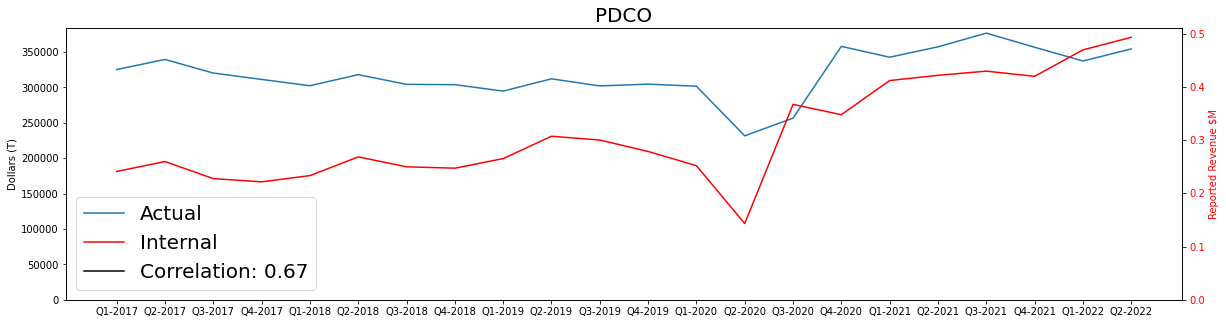

In [34]:
patterson_new = raw_to_agg(patterson_clean)
twinx(get_tpseries(patterson_new[:-1]), patterson_reported, patterson_new['production'][:-1], "PDCO",'Dollars (T)')

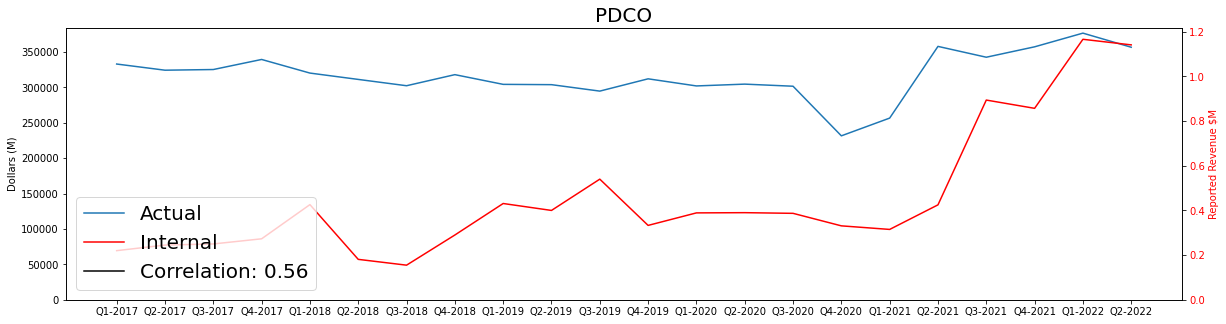

In [45]:
patterson_new = raw_to_agg(patterson_clean)
twinx(get_tpseries(patterson_new[:-1]), patterson_reported[:-2], patterson_new['production'][:-1], "PDCO")